In [1]:
import os
import pandas as pd
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, stats
%matplotlib inline

In [2]:
working_dir = os.getcwd()
data_dir = os.path.join(working_dir, "../..", "data")
data_dir

'/home/pierre/research/neurotech/brain-correlations/code/analysis/../../data'

In [3]:
def merge_files(fnames):
    ps = []
    for fname in fnames:
        p = pd.read_csv(os.path.join(data_dir, fname))
        ps.append(p)

    out = []
    for ps0, ps1 in zip(ps, ps[1:]):
        t0 = np.array(ps0['timestamps'])
        t1 = np.array(ps1['timestamps'])
        dt = t1[0] - t0[-1]

        fs0 = 1/np.mean(np.diff(t0))
        fs1 = 1/np.mean(np.diff(t1))
        fs = (fs0 + fs1) / 2.0

        tt = np.arange(t0[-1], t1[0], 1/fs)
        eeg = np.zeros((tt.shape[0], 4))
        marker = np.zeros(tt.shape[0])

        dd = pd.DataFrame(np.hstack([tt[:, np.newaxis], eeg, marker[:, np.newaxis]]),
                          columns=ps[0].columns)

        out.append(ps0)
        out.append(dd)

    out.append(ps[-1])
    return pd.concat(out)

In [4]:
"""Load Pierre Raw Data"""
fnames = ["data_pierre_1.csv", "data_pierre_2.csv"]
pierre = merge_files(fnames)

In [5]:
pierre_t = np.array(pierre['timestamps'])
pierre_data = np.array(pierre.ix[:,1:5])

In [6]:
"""Load Gaby Raw Data"""
gaby = pd.read_csv(os.path.join(data_dir, "data_gaby.csv"))
gaby_t = np.array(gaby['timestamps'])
gaby_data = np.array(gaby.ix[:,1:5])

In [7]:
print("gaby's start time is", pierre_t[0] - gaby_t[0], "earlier than pierre")
print("gaby's end time is", gaby_t[-1] - pierre_t[-1], "later than pierre")
print("need to trim gaby on both ends to fit pierre")

gaby's start time is 338.011000156 earlier than pierre
gaby's end time is -311.409000158 later than pierre
need to trim gaby on both ends to fit pierre


In [8]:
"""Trim gaby's start time to match pierre'"""
gaby_t = gaby_t[np.where(gaby_t >= pierre_t[0])]
gaby_data = gaby_data[np.where(gaby_t >= pierre_t[0])]

In [9]:
print("gaby's start time is", pierre_t[0] - gaby_t[0], "earlier than pierre")
print("gaby's end time is", gaby_t[-1] - pierre_t[-1], "later than pierre")

gaby's start time is -0.0160000324249 earlier than pierre
gaby's end time is -311.409000158 later than pierre


In [10]:
# """Trim gaby's end time to match pierre"""
# diverging_index = np.where(gaby_t >= pierre_t[-1])[0][0]
# gaby_t = gaby_t[:diverging_index]
# gaby_data = gaby_data[:diverging_index]

In [11]:
"""Trim pierre's end time to match gaby"""
diverging_index = np.where(pierre_t >= gaby_t[-1])[0][0]
pierre_t = pierre_t[:diverging_index]
pirere_data = pierre_data[:diverging_index]

In [12]:
print("gaby's start time is", pierre_t[0] - gaby_t[0], "earlier than pierre")
print("gaby's end time is", gaby_t[-1] - pierre_t[-1], "later than pierre")

gaby's start time is -0.0160000324249 earlier than pierre
gaby's end time is 0.00200009346008 later than pierre


In [13]:
gaby_fs = 1/np.mean(np.diff(gaby_t))
print("gaby's sampling frequency is", gaby_fs)
pierre_fs = 1/np.mean(np.diff(pierre_t))
print("pierre's sampling frequency is", pierre_fs)
print("Therefore, pierre has more samples within the same timecourse.")
print("pierre has", len(pierre_t) - len(gaby_t), "more samples than gaby within same timecourse.")
print("Need to downsample pierre to have same number of data points as gaby.")

gaby's sampling frequency is 180.066754045
pierre's sampling frequency is 195.960366386
Therefore, pierre has more samples within the same timecourse.
pierre has 71978 more samples than gaby within same timecourse.
Need to downsample pierre to have same number of data points as gaby.


In [14]:
"""Resampling pierre to gaby's length"""
pierre_data = signal.resample(pierre_data, len(gaby_t), axis=0)

In [32]:
print("pierre has", len(pierre_data) - len(gaby_data), "more samples than gaby within same timecourse.")

pierre has 0 more samples than gaby within same timecourse.


In [33]:
fs = gaby_fs

In [34]:
## filter signal to remove noise
b, a = signal.butter(4, (2/(fs/2), 30/(fs/2)), btype='bandpass')
pierre_smoothed = signal.filtfilt(b, a, pierre_data, axis=0)
gaby_smoothed = signal.filtfilt(b, a, gaby_data, axis=0)

In [36]:
window = fs
step = fs/4
corr = []
times = []

#advance window of 200 samples by 25 samples each time
## take correlation between signals across each sample
for index in np.arange(0, len(pierre_smoothed), step):
    start = int(index)
    end = int(start + window)
#     w1 = pierre_smoothed[start:end]
#     w2 = gaby_smoothed[start:end]
    freqs, w1 = signal.welch(pierre_smoothed[start:end], fs=fs, axis=0)
    freqs, w2 = signal.welch(gaby_smoothed[start:end], fs=fs, axis=0)
    good = (freqs >= 2) & (freqs <= 25)
    w1 = np.log(w1[good])
    w2 = np.log(w2[good])
    
    ## average the correlation across each channel
    r = 0
    for c in range(w1.shape[1]): #for each electrode
        r += stats.pearsonr(w1[:, c], w2[:, c])[0] #correlate that electrode between gaby and pierre
    r /= w1.shape[1] #average correlation across electrodes
    
    mid = (start+end)/2 # middle sample
    t = mid / fs # convert middle sample to time
    
    times.append(t)
    corr.append(r)

times = np.array(times)
corr = np.array(corr)

/home/pierre/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 180, using nperseg = 180
  .format(nperseg, input_length))
/home/pierre/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 148, using nperseg = 148
  .format(nperseg, input_length))
/home/pierre/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 103, using nperseg = 103
  .format(nperseg, input_length))
/home/pierre/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 58, using nperseg = 58
  .format(nperseg, input_length))
/home/pierre/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 13, using nperseg = 13
  .format(nperseg, input_length))
/home/pierre/.local

In [28]:
corr = np.abs(corr)

In [23]:
def moving_average(sig, n=3):
    return signal.convolve(sig, np.ones(n)/n, mode='same')

In [26]:
corr[np.isnan(corr)] = 0

In [108]:
np.savetxt("times_100_2.txt", times[::4])
np.savetxt("corr_100_2.txt", moving_average(corr,100)[::4])

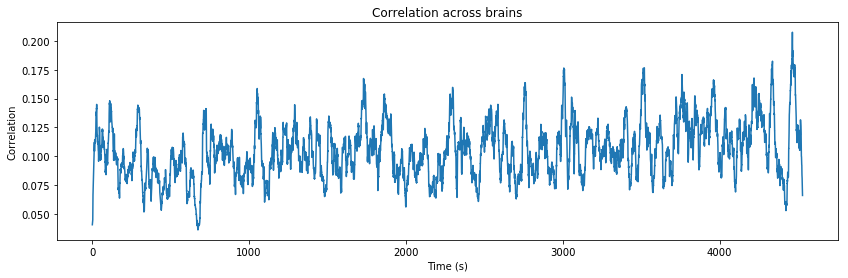

In [29]:
figure(figsize=(14,4))
plot(times, moving_average(corr,100))
xlabel('Time (s)')
ylabel('Correlation')
_ = title('Correlation across brains')

In [100]:
"""Syncing to video content"""
start_white = 1492292390.07327
start_black = 1492292391.07712
end_white = 1492297704.94143
end_black = 1492297705.94569

In [101]:
print("Brain recordings lasted for", int(times[-1]), "seconds")

Brain recordings lasted for 4528 seconds


In [102]:
print("Brain recordings started", pierre_t[0] - start_black, "seconds after black screen")

Brain recordings started 124.2988801 seconds after black screen


In [103]:
print("Brain recordings ended", end_black - pierre_t[-1], "seconds before black screen")

Brain recordings ended 661.990689993 seconds before black screen
